In [1]:
import os
import sys

import numpy as np

## Plotting stuff
import matplotlib.pyplot as plt
import matplotlib as mpl

## For colorbar 
from mpl_toolkits.axes_grid1 import make_axes_locatable

## Get physical constants from Scipy
import scipy.constants as con

## For fitting
import scipy.optimize as opt

## For matlab loading
import scipy.io as sio

module_path = os.path.abspath(os.path.join('..', '..', '..'))
sys.path.append(module_path)
## Load custom package modules
from misloc_mispol_package.calc import BEM_simulation_wrapper as bem
from misloc_mispol_package.calc import fitting_misLocalization as fit
from misloc_mispol_package.calc import coupled_dipoles as cp
from misloc_mispol_package.optics import diffraction_int as diffi
from misloc_mispol_package.optics import fibonacci as fib
from misloc_mispol_package.optics import anal_foc_diff_fields as adf

In [2]:
## Parameter setting needs to be in cell following mpl import for some reason 
## https://github.com/jupyter/notebook/issues/3385
##
## Default parameters inspired by 
## http://nipunbatra.github.io/2014/08/latexify/
params = {
    'text.latex.preamble': ['\\usepackage{gensymb}'],
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'image.cmap': 'magma',
    'axes.grid': False,
    'figure.dpi': 200,  # to adjust notebook inline plot size
    'savefig.dpi': 200,  # to adjust notebook inline plot size
#     'axes.labelsize': 12, # fontsize for x and y labels (was 10)
    'axes.titlesize': 14,
    'font.size': 8, # was 10
#     'savefig.dpi': 150,  # to adjust notebook inline plot size
    'axes.labelsize': 10, # fontsize for x and y labels (was 10)
    'axes.titlesize': 10,
    'font.size': 8, # was 10
    'legend.fontsize': 8, # was 10
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'text.usetex': True,
    'figure.figsize': [3.39, 2.10],
    'font.family': 'serif',
    'figure.max_open_warning':10001
}
mpl.rcParams.update(params)

In [3]:
## Some useful numerical constants
hbar = con.physical_constants['Planck constant over 2 pi in eV s'][0]
c = con.physical_constants['speed of light in vacuum'][0]*1e2 #cm/m

eps_b = 1.778 ## Water
cm_per_nm = 1E-7

hres_obs_pts = diffi.observation_points(
    -1000*cm_per_nm, 1000*cm_per_nm, -1000*cm_per_nm, 1000*cm_per_nm, 201)

In [4]:
wl = 633
k = 1240/wl/hbar/c
xi, y = hres_obs_pts[1:]

Generate a model image

/Users/chair/Documents/Academia/SuperRes/Biteen_colab/Mispolarization/python/misloc_mispol_package/optics/anal_foc_diff_fields.py:27: RuntimeWarning: divide by zero encountered in true_divide
  sphj1_on_krho = spf.spherical_jn( 1, k*rho(xi, y) )/(k*rho(xi, y))
/Users/chair/Documents/Academia/SuperRes/Biteen_colab/Mispolarization/python/misloc_mispol_package/optics/anal_foc_diff_fields.py:27: RuntimeWarning: invalid value encountered in true_divide
  sphj1_on_krho = spf.spherical_jn( 1, k*rho(xi, y) )/(k*rho(xi, y))
/Users/chair/Documents/Academia/SuperRes/Biteen_colab/Mispolarization/python/misloc_mispol_package/optics/anal_foc_diff_fields.py:30: RuntimeWarning: divide by zero encountered in true_divide
  j2_on_krho = spf.jv(2, k*rho(xi, y) )/(k*rho(xi, y))
/Users/chair/Documents/Academia/SuperRes/Biteen_colab/Mispolarization/python/misloc_mispol_package/optics/anal_foc_diff_fields.py:30: RuntimeWarning: invalid value encountered in true_divide
  j2_on_krho = spf.jv(2, k*rho(xi, y) )/(

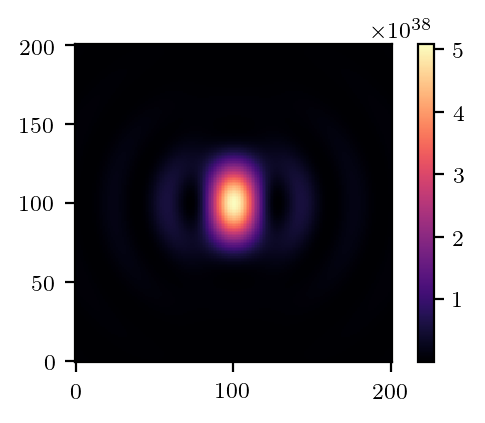

In [5]:
test_field_x = adf.E_field(0, hres_obs_pts[1], hres_obs_pts[2], 1240/wl/hbar/c)
test_im_x = (c/(8*np.pi))* (np.abs(test_field_x)**2.).sum(axis=0)
plt.imshow(test_im_x)
plt.colorbar()

Numerically compute and image from the dipole fields

In [6]:
## Define integration points
#### parameters for integration
lens_points = 1000
max_theta = np.pi/2
obj_f = 1

sphere_points = fib.fib_alg_k_filter(
    num_points=lens_points,
    max_ang=max_theta
    )
# Convert spherical coordinates to Caresian.
cart_points_on_sph = fib.sphere_to_cart(
    sphere_points[:,0],
    sphere_points[:,1],
    obj_f*np.ones(np.shape(sphere_points[:,0]))
    )

## Define dipole filds at integration points
## G * p
E_at_integr_pts = cp.G(1240/wl, cart_points_on_sph, 1) @ np.array([[1, 0, 0]]).T
E_at_integr_pts = E_at_integr_pts[...,0]

diffracted_E = diffi.perform_integral(
    scattered_E=E_at_integr_pts,
    scattered_sph_coords=sphere_points,
    obser_pts=hres_obs_pts[0]*np.array([[1,-1]]),
    z=0,
    obj_f=1,
    tube_f=1,
    k=(1240/wl/hbar)/c,
    alpha_1_max=np.pi/2
    )

image = (c/(8*np.pi))*np.real(
    np.sum(
        np.multiply(diffracted_E,
            np.conj(diffracted_E)
            ),
        axis=-1
        )
    ).reshape((201, 201))

given even number of points for Fibonacci lattice, 
  adding 1...


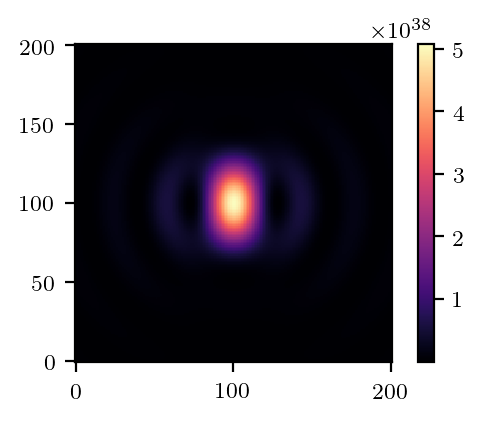

In [7]:
numerical_image = image
plt.imshow(numerical_image)
plt.colorbar()

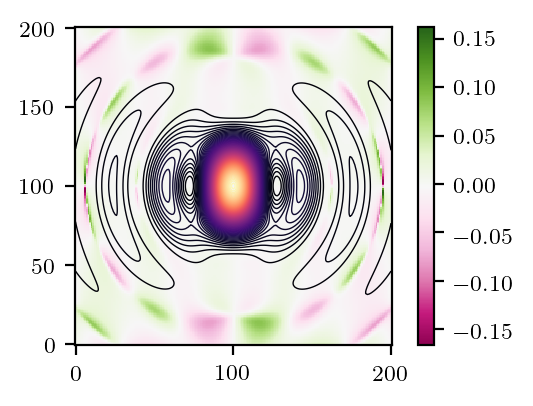

In [8]:
plt.imshow((test_im_x - numerical_image)/numerical_image, cmap=plt.cm.PiYG)
plt.colorbar()
plt.contour(numerical_image, levels=100, linewidths=0.5)


Cool, agreement is really good. The deviations only occur in the diffraction minima

try z

/Users/chair/Documents/Academia/SuperRes/Biteen_colab/Mispolarization/python/misloc_mispol_package/optics/anal_foc_diff_fields.py:75: RuntimeWarning: divide by zero encountered in true_divide
  j2_on_krho = spf.jv(2, k*rho(xi, y) )/(k*rho(xi, y))
/Users/chair/Documents/Academia/SuperRes/Biteen_colab/Mispolarization/python/misloc_mispol_package/optics/anal_foc_diff_fields.py:75: RuntimeWarning: invalid value encountered in true_divide
  j2_on_krho = spf.jv(2, k*rho(xi, y) )/(k*rho(xi, y))
/Users/chair/Documents/Academia/SuperRes/Biteen_colab/Mispolarization/python/misloc_mispol_package/optics/anal_foc_diff_fields.py:78: RuntimeWarning: divide by zero encountered in true_divide
  sphj0_on_krhosqrd = spf.spherical_jn(0, k*rho(xi, y) )/(k*rho(xi, y))**2.
/Users/chair/Documents/Academia/SuperRes/Biteen_colab/Mispolarization/python/misloc_mispol_package/optics/anal_foc_diff_fields.py:82: RuntimeWarning: invalid value encountered in add
  sphj0_on_krhosqrd


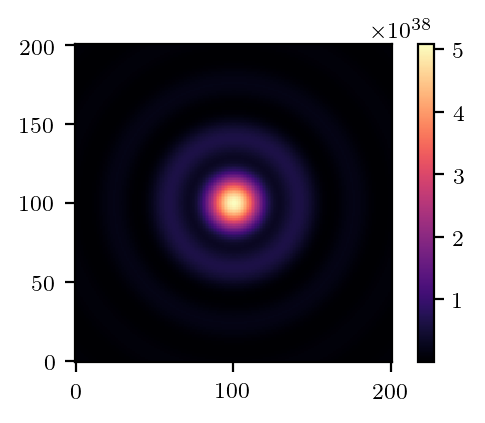

In [9]:
test_field_z = adf.E_pz(hres_obs_pts[1], hres_obs_pts[2], 1240/wl/hbar/c)
test_im_z = (c/(8*np.pi))* (np.abs(test_field_z)**2.).sum(axis=0)
plt.imshow(test_im_z)
plt.colorbar()

In [10]:
## Define dipole filds at integration points
## G * p
E_at_integr_pts_pz = cp.G(1240/wl, cart_points_on_sph, 1) @ np.array([[0, 0, 1]]).T
E_at_integr_pts_pz = E_at_integr_pts_pz[...,0]

diffracted_E_pz = diffi.perform_integral(
    scattered_E=E_at_integr_pts_pz,
    scattered_sph_coords=sphere_points,
    obser_pts=hres_obs_pts[0]*np.array([[1,-1]]),
    z=0,
    obj_f=1,
    tube_f=1,
    k=(1240/wl/hbar)/c,
    alpha_1_max=np.pi/2
    )

numerical_image_pz = (c/(8*np.pi))*np.real(
    np.sum(
        np.multiply(diffracted_E_pz,
            np.conj(diffracted_E_pz)
            ),
        axis=-1
        )
    ).reshape((201, 201))

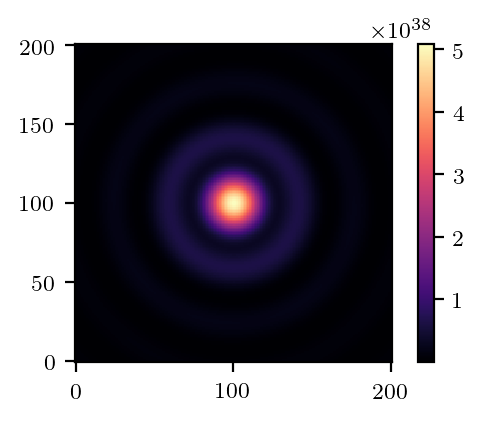

In [11]:
plt.imshow(numerical_image_pz)
plt.colorbar()

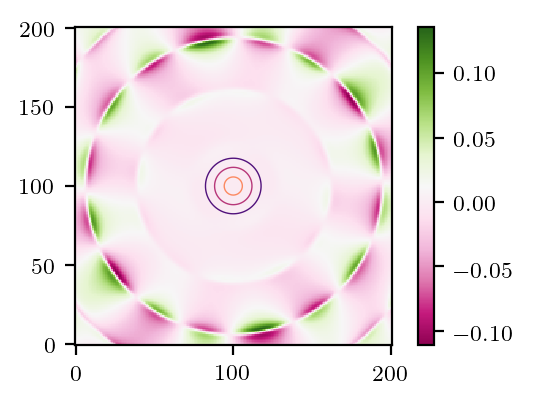

In [24]:
plt.imshow((test_im_z - numerical_image_pz)/numerical_image_pz, cmap=plt.cm.PiYG)
plt.colorbar()
plt.contour(numerical_image_pz, levels=3, linewidths=0.5)


In [25]:
## Relative error at center of Image
((test_im_z - numerical_image_pz)/numerical_image_pz)[100,100]

-0.0004995631135510727

In [ ]:
plt.imshow((test_im_z - numerical_image_pz), cmap=plt.cm.PiYG)
plt.colorbar()
plt.contour(numerical_image_pz, levels=5, linewidths=0.5)
